# 패키지 로드 및 데이터 불러오기

In [380]:
setwd("C:\\Users\\yy\\Desktop\\dacon")

In [381]:
library(data.table) # Fast CSV read
library(tidyverse)    #Visualisation
library(bit64)
library(scales)
library(gridExtra)
library(ggthemes)

In [382]:
jeju=fread("jeju_financial_life_data.csv",encoding="UTF-8",na.strings=c("NA","NaN", ""))

In [383]:
cat("Jeju_Financial_Life_Data : (" , nrow(jeju) , "," , ncol(jeju) , ")  ")

Jeju_Financial_Life_Data : ( 10422 , 27 )  

In [384]:
#형식 변환
jeju= jeju  %>% mutate_if(is.integer, list(~as.numeric(.)))
jeju= jeju  %>% mutate_if(is.integer64, list(~as.numeric(.)))

In [385]:
str(jeju)

'data.frame':	10422 obs. of  27 variables:
 $ zip_cd             : num  63299 63560 63560 63560 63560 ...
 $ year_month         : num  201902 201902 201902 201902 201902 ...
 $ x_axis             : num  127 126 126 126 126 ...
 $ y_axis             : num  33.5 33.2 33.2 33.2 33.2 ...
 $ sex                : num  1 1 2 1 1 2 1 1 1 1 ...
 $ age                : num  54 59 49 54 49 39 64 44 54 44 ...
 $ job_majorc         : num  0 0 0 0 0 ...
 $ job_smallc         : num  0.167 0.125 0.25 0.182 0.25 ...
 $ job_public         : num  0 0 0 0.0909 0 ...
 $ job_profession     : num  0 0 0 0.0909 0 ...
 $ job_self           : num  0.167 0.375 0.125 0.364 0.25 ...
 $ job_none           : num  0.5 0.5 0.625 0.273 0.5 ...
 $ job_other          : num  0.167 0 0 0 0 ...
 $ avg_income         : num  37188000 35378000 32119000 64746000 29578000 ...
 $ med_income         : num  33000000 32000000 34000000 68200000 29700000 32500000 37000000 52000000 38000000 33500000 ...
 $ avg_spend          : num  261

## PCA

* PCA는 데이터의 분산(variance)을 최대한 보존하면서 서로 직교하는 새 기저(축)를 찾아, 고차원 공간의 표본들을 선형 연관성이 없는 저차원 공간으로 변환하는 기법입니다. 제주도 데이터는 지리적 요인, 직업, 소득, 소비, 부채 등 다양한 정보가 담겨 있기 때문에 단순히 몇개의 요인들로 고객들을 세분화하기가 쉅지 않습니다. 따라서 PCA를 통해 차원을 축소하고 이후 kmeans를 통해 군집을 분류하겠습니다.

In [386]:
# 날짜만 제외하고 PCA
df <- jeju[,-c(2)]
pca_mod <- prcomp(df,scale=TRUE)  # compute principal components

# Data frame of principal components ----------------------
df_pc <- data.frame(pca_mod$x)  # dataframe of principal components

In [387]:
summary(pca_mod)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.2609 1.8407 1.50011 1.34601 1.26488 1.13972 1.08085
Proportion of Variance 0.1966 0.1303 0.08655 0.06968 0.06154 0.04996 0.04493
Cumulative Proportion  0.1966 0.3269 0.41347 0.48316 0.54469 0.59465 0.63958
                           PC8     PC9    PC10   PC11    PC12    PC13    PC14
Standard deviation     0.97364 0.94778 0.90423 0.8743 0.85226 0.82357 0.81117
Proportion of Variance 0.03646 0.03455 0.03145 0.0294 0.02794 0.02609 0.02531
Cumulative Proportion  0.67604 0.71059 0.74204 0.7714 0.79938 0.82546 0.85077
                          PC15    PC16    PC17    PC18    PC19   PC20    PC21
Standard deviation     0.77880 0.76859 0.73759 0.72360 0.67485 0.6470 0.57494
Proportion of Variance 0.02333 0.02272 0.02092 0.02014 0.01752 0.0161 0.01271
Cumulative Proportion  0.87410 0.89682 0.91774 0.93788 0.95540 0.9715 0.98421
                          PC22    PC23    

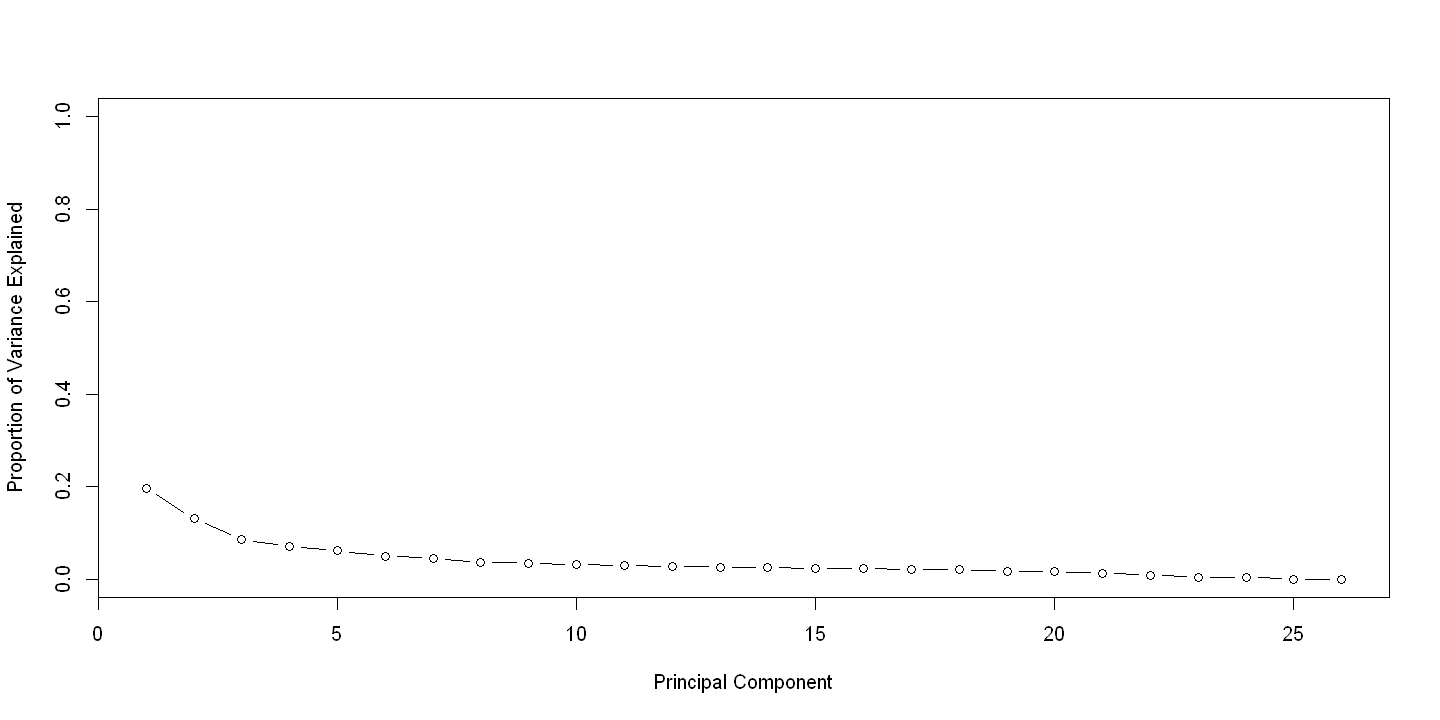

In [388]:
options(repr.plot.width=12, repr.plot.height=6)

# Screeplot
pr_var <-  pca_mod$sdev ^ 2
pve <- pr_var / sum(pr_var)
plot(pve, xlab = "Principal Component", ylab = "Proportion of Variance Explained", ylim = c(0,1), type = 'b')

* PC12부터 분산의 비율이 크게 감소하지 않고 약 80%의 비율을 설명하고 있습니다.
    따라서 12차원의 데이터로 K-means를 수행하겠습니다.

In [389]:
# min-max scale
normalize <- function(x){
    return ( (x-min(x)) / (max(x)-min(x)) )
}

In [390]:
train=as.data.frame(lapply(df_pc[,1:12],normalize))

* k-means 군집 분석은 이상치에 민감하다는 단점이 있기 때문에 min-max scale을 통하여 표준화를 해주었습니다.

## K-means

[1] 687.8114 572.7269 515.9301 461.2856 422.1350 400.7493 384.8855 370.5024
 [9] 353.7485 341.9052 332.4282 325.9034 319.7923 309.3799 301.7070

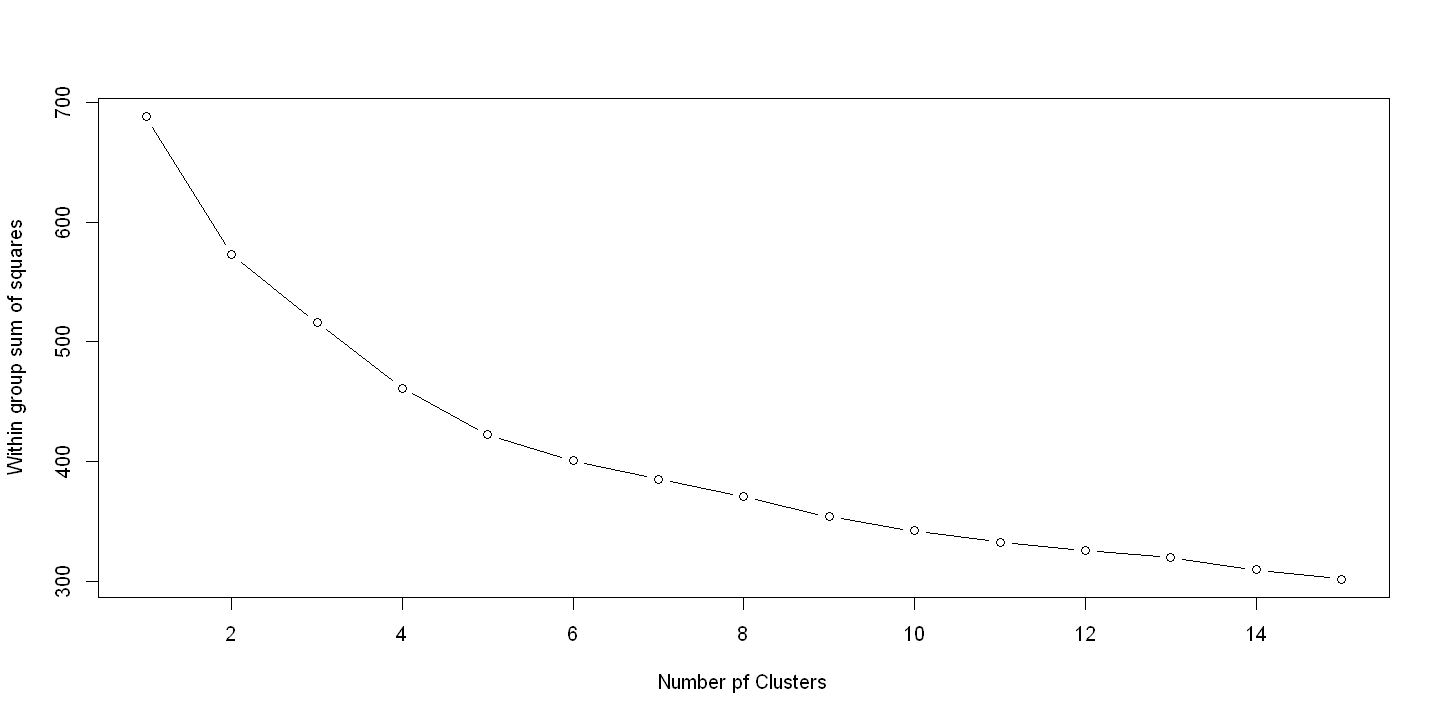

In [391]:
wssplot=function(data,nc=15,seed=1234,plot=TRUE){
        wss <- (nrow(data)-1)*sum(apply(data,2,var))
        
        for( i in 2:nc){
                set.seed(seed)
                wss[i]<-sum(kmeans(data,centers=i)$withinss)
        }
        if(plot) plot(1:nc,wss,type="b",xlab="Number pf Clusters",ylab="Within group sum of squares")
        wss
}

wssplot(train)

적절한 군집의 개수를 정해주기 위해서 wssplot으로 개수를 정해줍니다.

wssplot에서의 y축 즉, Within group sum of squaresd은 그룹 내 이질성을 뜻하며, k-means의 목적이 동질성을 높이고 이질성을 낮추는데 있기 

때문에 Within group sum of squaresd가 낮은 적절한 k의 개수가 필요합니다. 위 그래프에서는 k가 7부터 wss가 감소하는 값이 작아지므로

군집의 개수를 7으로 정해주었습니다.

In [392]:
set.seed(707)
fit.km=kmeans(train,7,nstart=25)

In [393]:
jeju$label=fit.km$cluster

# 시각화 및 해석

* 군집을 7개로 나누었기 때문에 지역에 따른 직업,부채 관련 정보에 초점을 맞추었습니다.

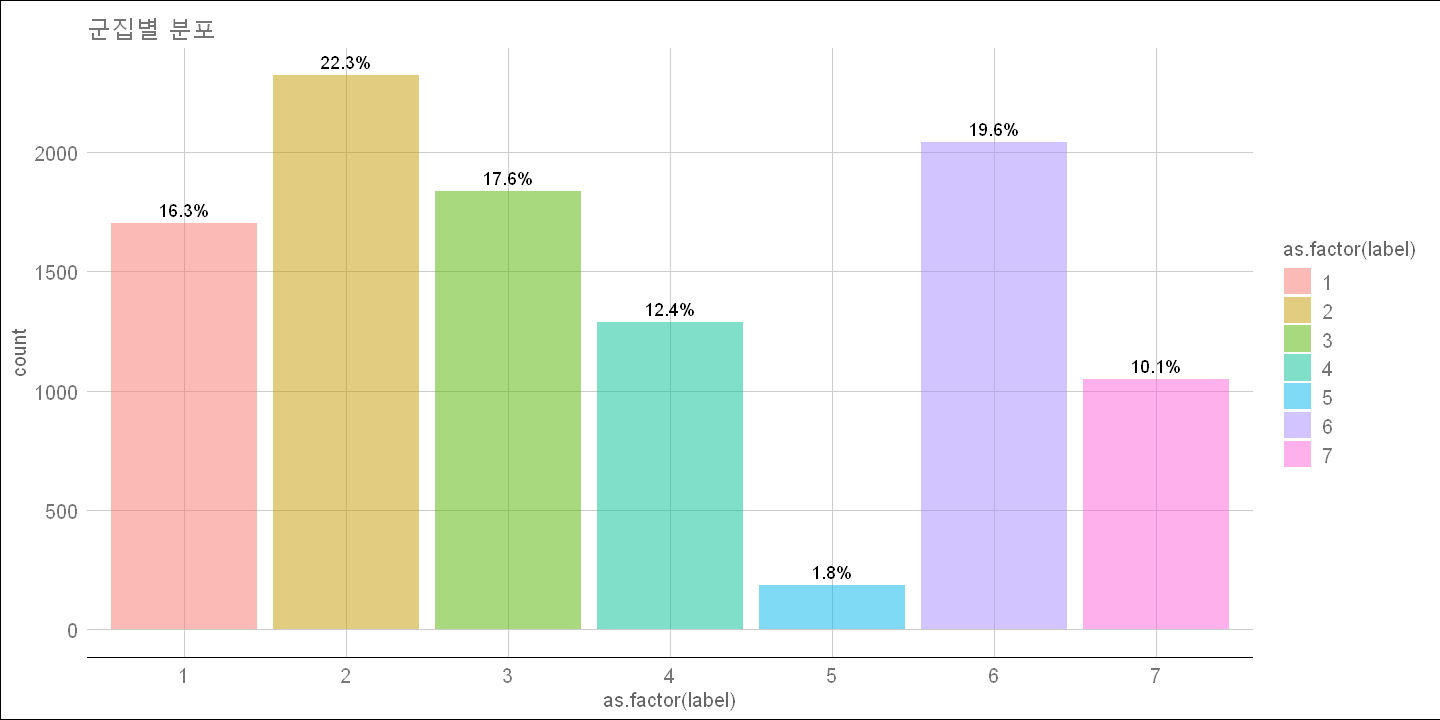

In [394]:
ggplot(jeju,aes(as.factor(label),fill=as.factor(label)))+
    geom_bar(alpha=0.5)+
    theme(plot.title = element_text(hjust = 0.5))+
    geom_text(aes(label =scales::percent(..count../sum(..count..))),stat = 'count',vjust = -0.5) +
    ggtitle("군집별 분포 ")+
    theme_gdocs()

5번 군집은 데이터에서 1.8%로만 군집이 형성되었고, 제일 비중이 높은 군집은 2번 군집으로 데이터의 약 22%을 차지하고 있습니다.

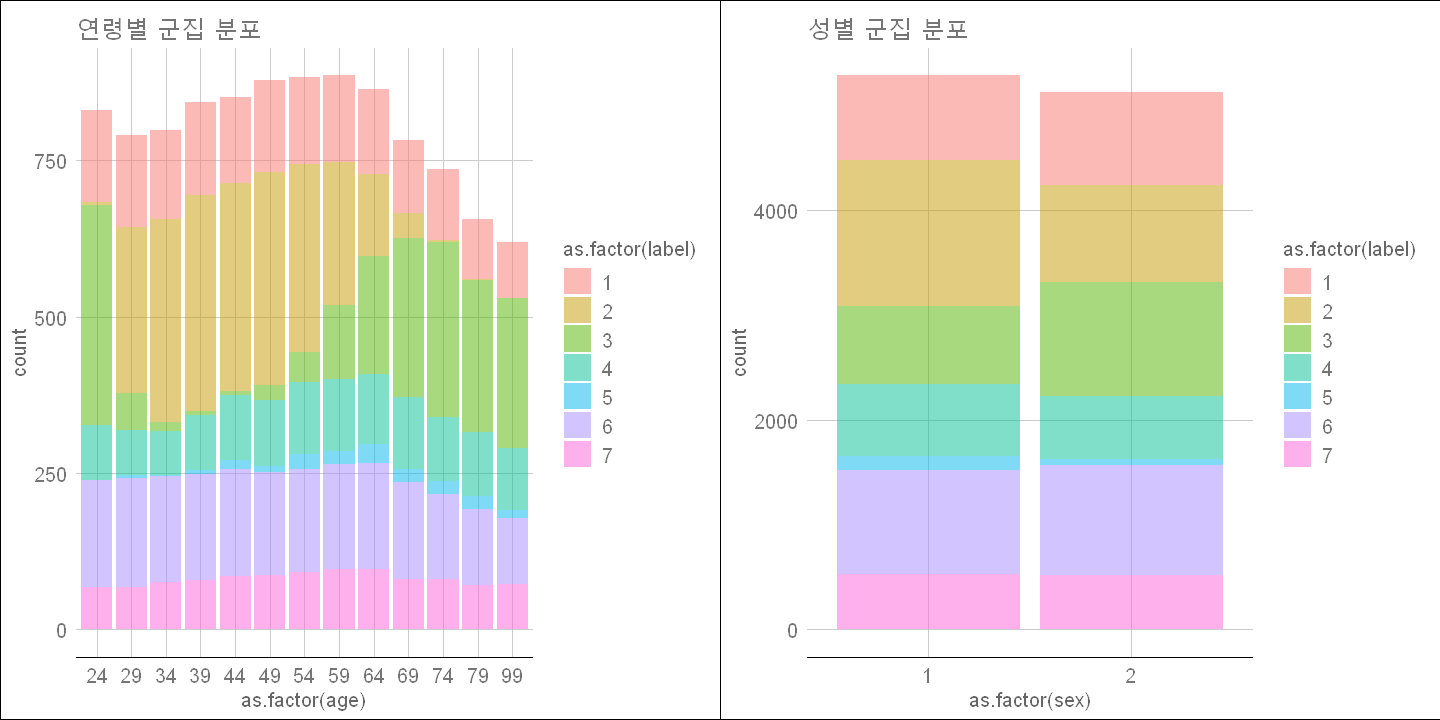

In [395]:
options(repr.plot.width=12, repr.plot.height=6)

p1=ggplot(jeju,aes(as.factor(age),fill=as.factor(label)))+
    geom_bar(alpha=0.5)+
    theme(plot.title = element_text(hjust = 0.5))+
    ggtitle("연령별 군집 분포")+
    theme_gdocs()

p2=ggplot(jeju,aes(as.factor(sex),fill=as.factor(label)))+
    geom_bar(alpha=0.5)+
    theme(plot.title = element_text(hjust = 0.5))+
    ggtitle("성별 군집 분포")+
    theme_gdocs()

grid.arrange(p1,p2,ncol=2)

## 군집별 소득 분포

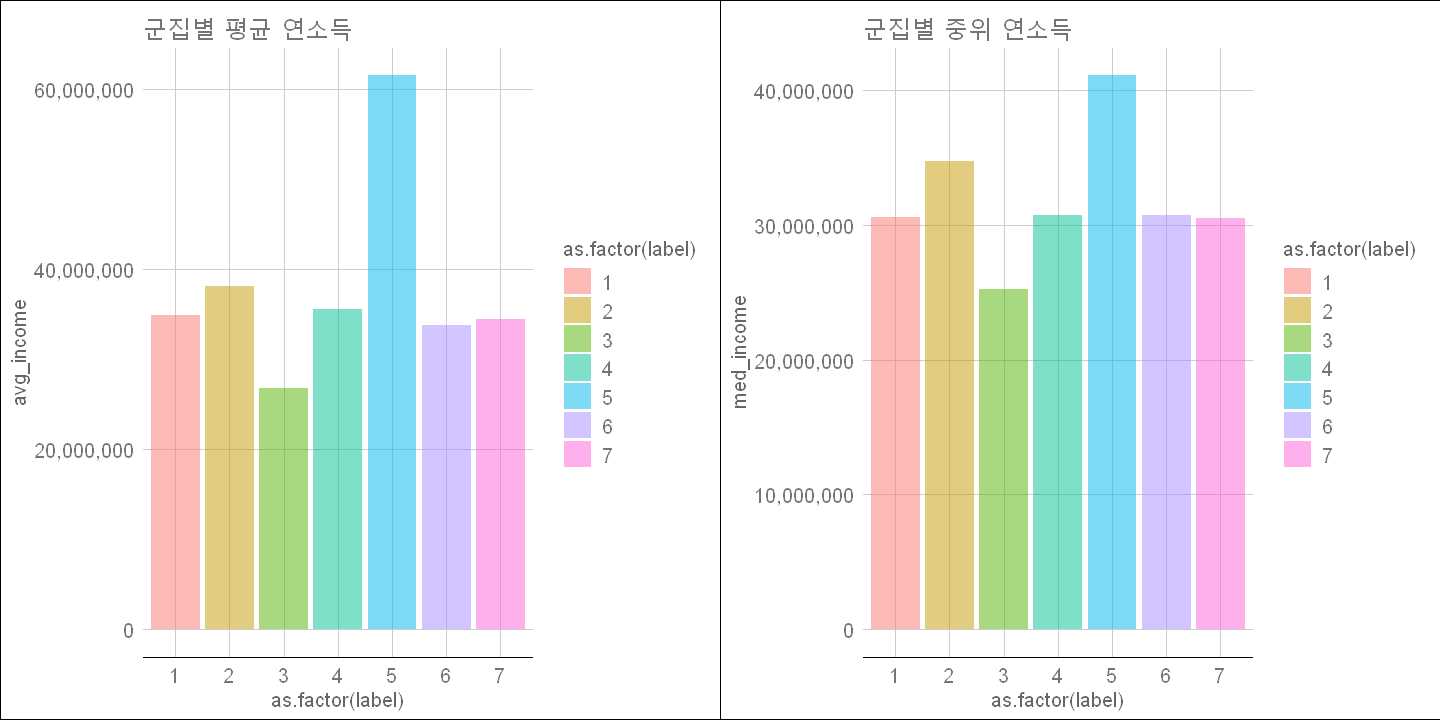

In [396]:
options(repr.plot.width=12, repr.plot.height=6)

p1=ggplot(jeju,aes(as.factor(label),avg_income,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 연소득")

p2=ggplot(jeju,aes(as.factor(label),med_income,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 중위 연소득")

grid.arrange(p1,p2,ncol=2)

5번 군집이 표본의 갯수에 비해 평균연소득과 중위연소득이 다른 군집보다 굉장히 높게 분포되어 있습니다.

이는 데이터에서 이상치들이 군집으로 형성됬다고 유추할 수 있습니다.

또한 3번 군집을 제외하고 나머지 군집의 연소득은 비슷한 수준입니다.

## 군집별 소비 분포

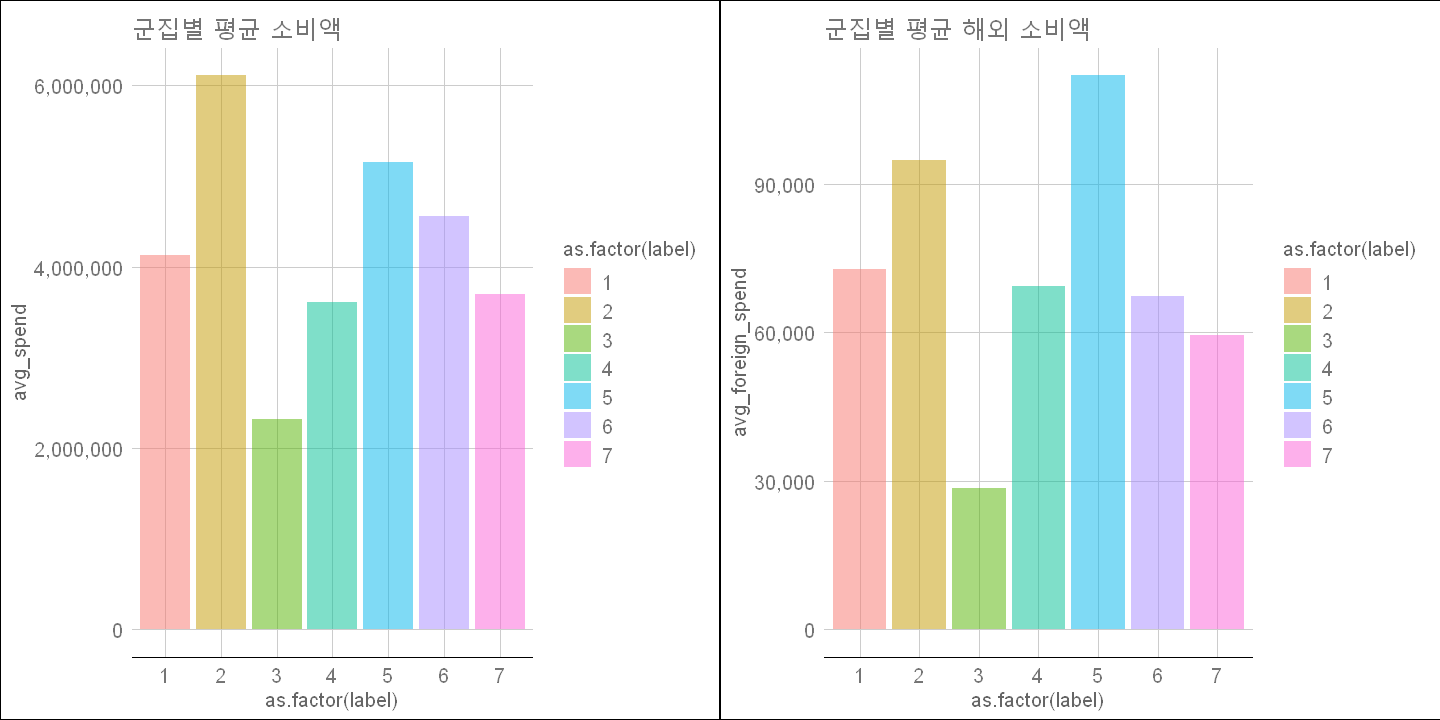

In [397]:
p1=ggplot(jeju,aes(as.factor(label),avg_spend,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 소비액")

p2=ggplot(jeju,aes(as.factor(label),avg_foreign_spend,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 해외 소비액")

grid.arrange(p1,p2,ncol=2)

2번 군집이 위에서 본 연소득이 가장 큰 5번 군집에 비해 국내 소비액이 가장 높습니다.

5번 군집은 해외 소비액의 평균이 가장 높지만 해외 소비액의 차이가 그렇게 크지 않다는 점을 감안하면 큰 의미는 없어 보입니다.

3번 군집은 연소득이 가장 낮으면서 소비도 역시 가장 낮은 경향을 보이고 있습니다.

## 군집별 직업 분포

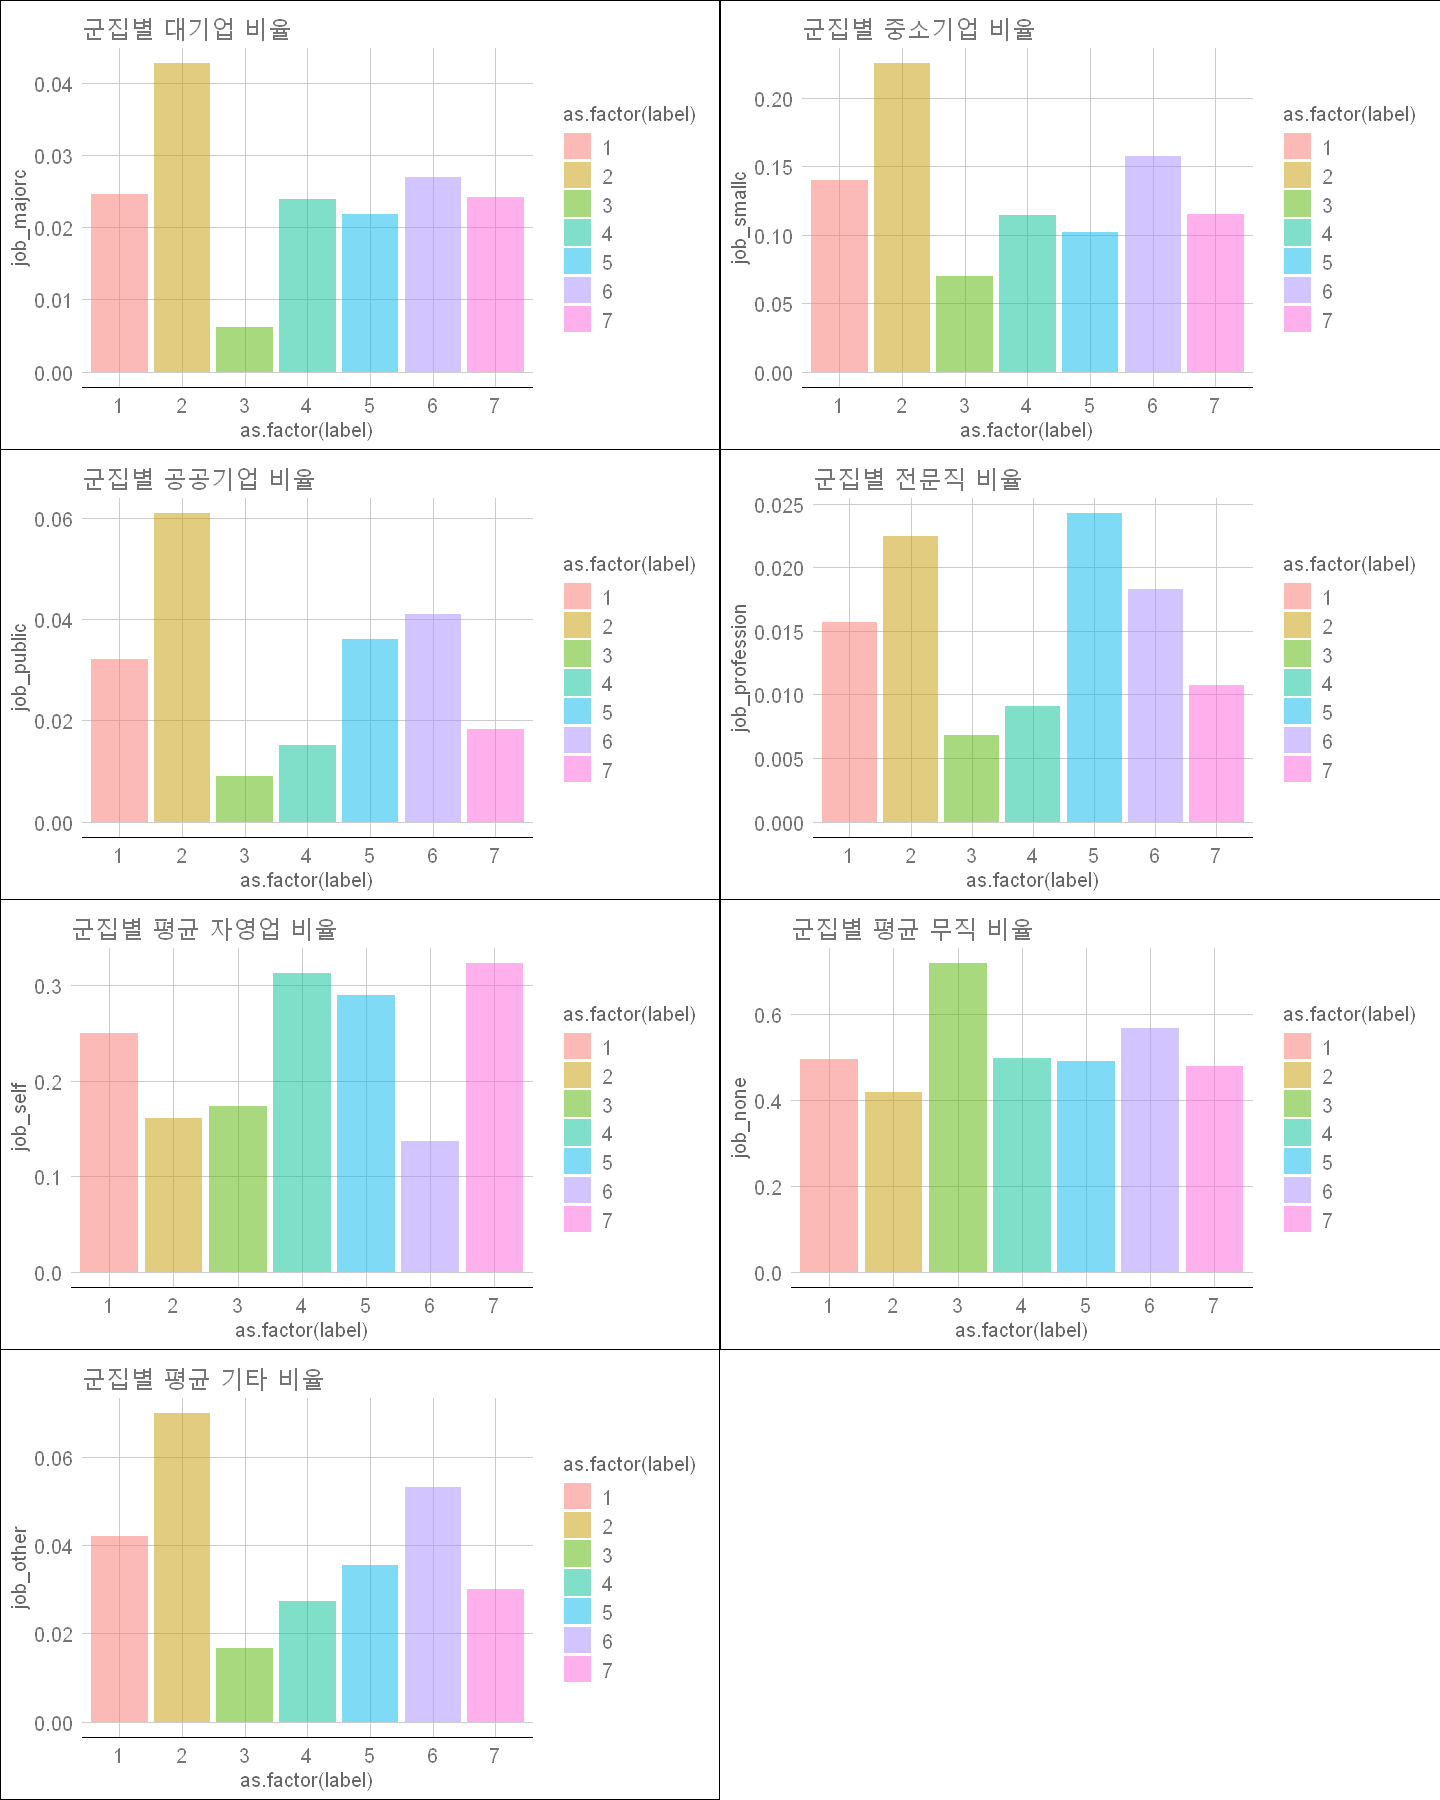

In [398]:
options(repr.plot.width=12, repr.plot.height=15)

p1=ggplot(jeju,aes(as.factor(label),job_majorc,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 대기업 비율")

p2=ggplot(jeju,aes(as.factor(label),job_smallc,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 중소기업 비율")

p3=ggplot(jeju,aes(as.factor(label),job_public,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 공공기업 비율")

p4=ggplot(jeju,aes(as.factor(label),job_profession,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 전문직 비율")

p5=ggplot(jeju,aes(as.factor(label),job_self,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 자영업 비율")

p6=ggplot(jeju,aes(as.factor(label),job_none,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 무직 비율")

p7=ggplot(jeju,aes(as.factor(label),job_other,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 기타 비율")

grid.arrange(p1,p2,p3,p4,p5,p6,p7,nrow=4)

군집들의 직업분포에서 전체적으로 무직의 비율이 높은 것을 알 수 있습니다.

2번 군집은 기업과 전문직,기타 에서 다른 군집들보다 높은 분포를 보이고 있습니다. 이는 2번 군집이 다른 군집보다 소비가 높은 이유를 설명해준다고 판단됩니다.

5번 군집은 전문직과 자영업으로 분포되고 자영업의 평균 비율이 0.3정도로 고소득의 자영업자들이 있음을 시사하고 있습니다. 

4번과 7번 군집의 경우 자영업의 비율이 매우 큰 비중을 차지합니다.

3번 군집은 소득,소비가 낮아 생각대로 무직의 비율이 가장 높은 것이 확인됩니다.

## 군집별 부채 분포

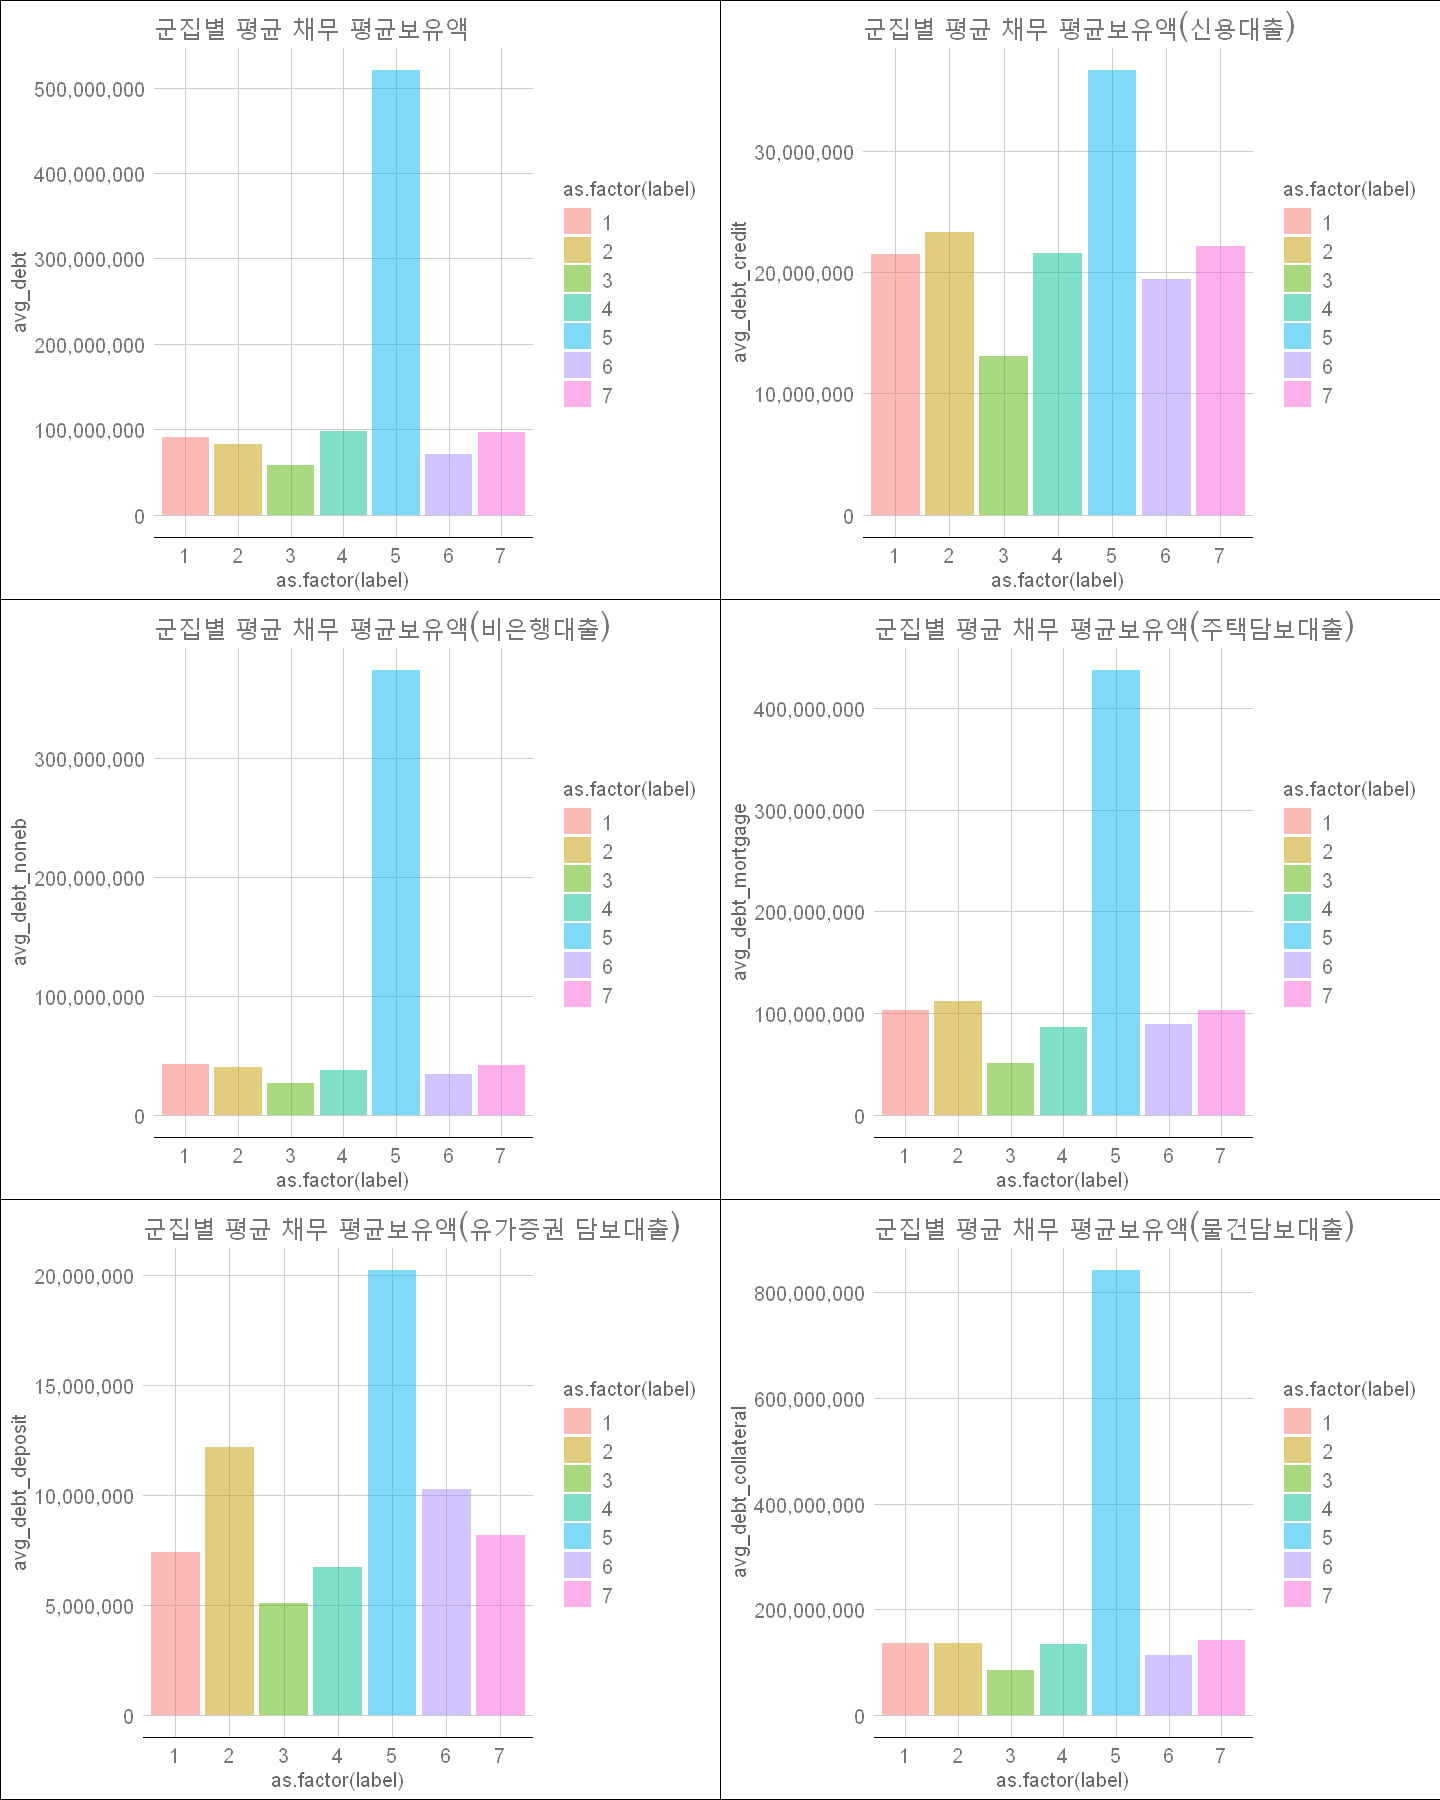

In [399]:
options(repr.plot.width=12, repr.plot.height=15)

p1=ggplot(jeju,aes(as.factor(label),avg_debt,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 채무 평균보유액")

p2=ggplot(jeju,aes(as.factor(label),avg_debt_credit,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 채무 평균보유액(신용대출)")

p3=ggplot(jeju,aes(as.factor(label),avg_debt_noneb,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 채무 평균보유액(비은행대출)")

p4=ggplot(jeju,aes(as.factor(label),avg_debt_mortgage,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 채무 평균보유액(주택담보대출)")

p5=ggplot(jeju,aes(as.factor(label),avg_debt_deposit,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 채무 평균보유액(유가증권 담보대출)")

p6=ggplot(jeju,aes(as.factor(label),avg_debt_collateral,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(label=comma)+
    theme_gdocs()+
    ggtitle("군집별 평균 채무 평균보유액(물건담보대출)")


grid.arrange(p1,p2,p3,p4,p5,p6,nrow=3)

5번 군집이 채무 평균보유액이 전체적으로 높게 형성되어 있습니다.

이는 빚도 자산이라는 점을 감안하면, 소득이 높게 형성될수록 채무도 높은 것이라 생각됩니다.

## 군집별 신용 / 부동산 / 자동차 분포

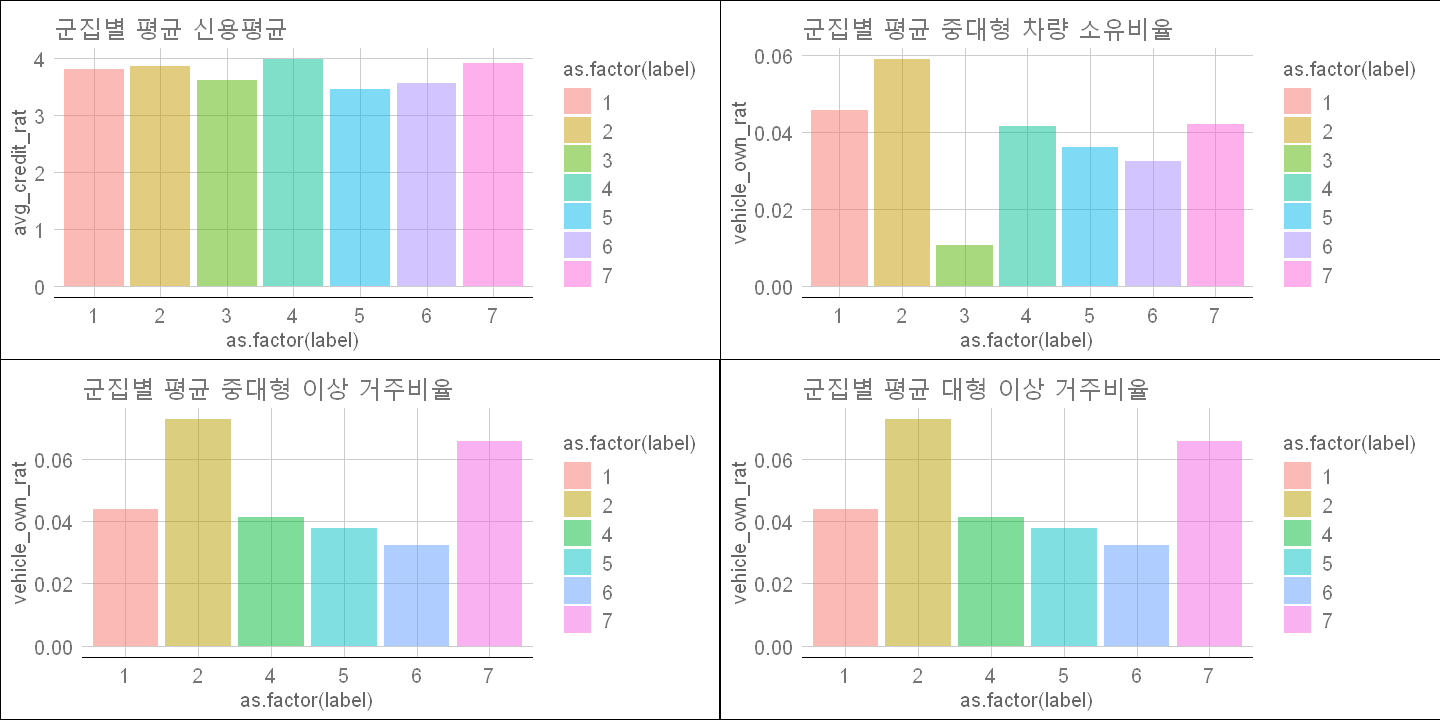

In [400]:
options(repr.plot.width=12, repr.plot.height=6)

p1=ggplot(jeju,aes(as.factor(label),avg_credit_rat,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 신용평균")

p2=ggplot(jeju,aes(as.factor(label),vehicle_own_rat,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 중대형 차량 소유비율")

p3= jeju %>% filter(medium_resid_rat>=0) %>% 
    ggplot(aes(as.factor(label),vehicle_own_rat,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 중대형 이상 거주비율")

p4= jeju %>% filter(medium_resid_rat>=0) %>% 
    ggplot(aes(as.factor(label),vehicle_own_rat,fill=as.factor(label)))+
    geom_bar(alpha=0.5,stat = "summary", fun.y = "mean")+
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous()+
    theme_gdocs()+
    ggtitle("군집별 평균 대형 이상 거주비율")

grid.arrange(p1,p2,p3,p4,ncol=2)

# 위도,경도를 활용한 군집별 특성

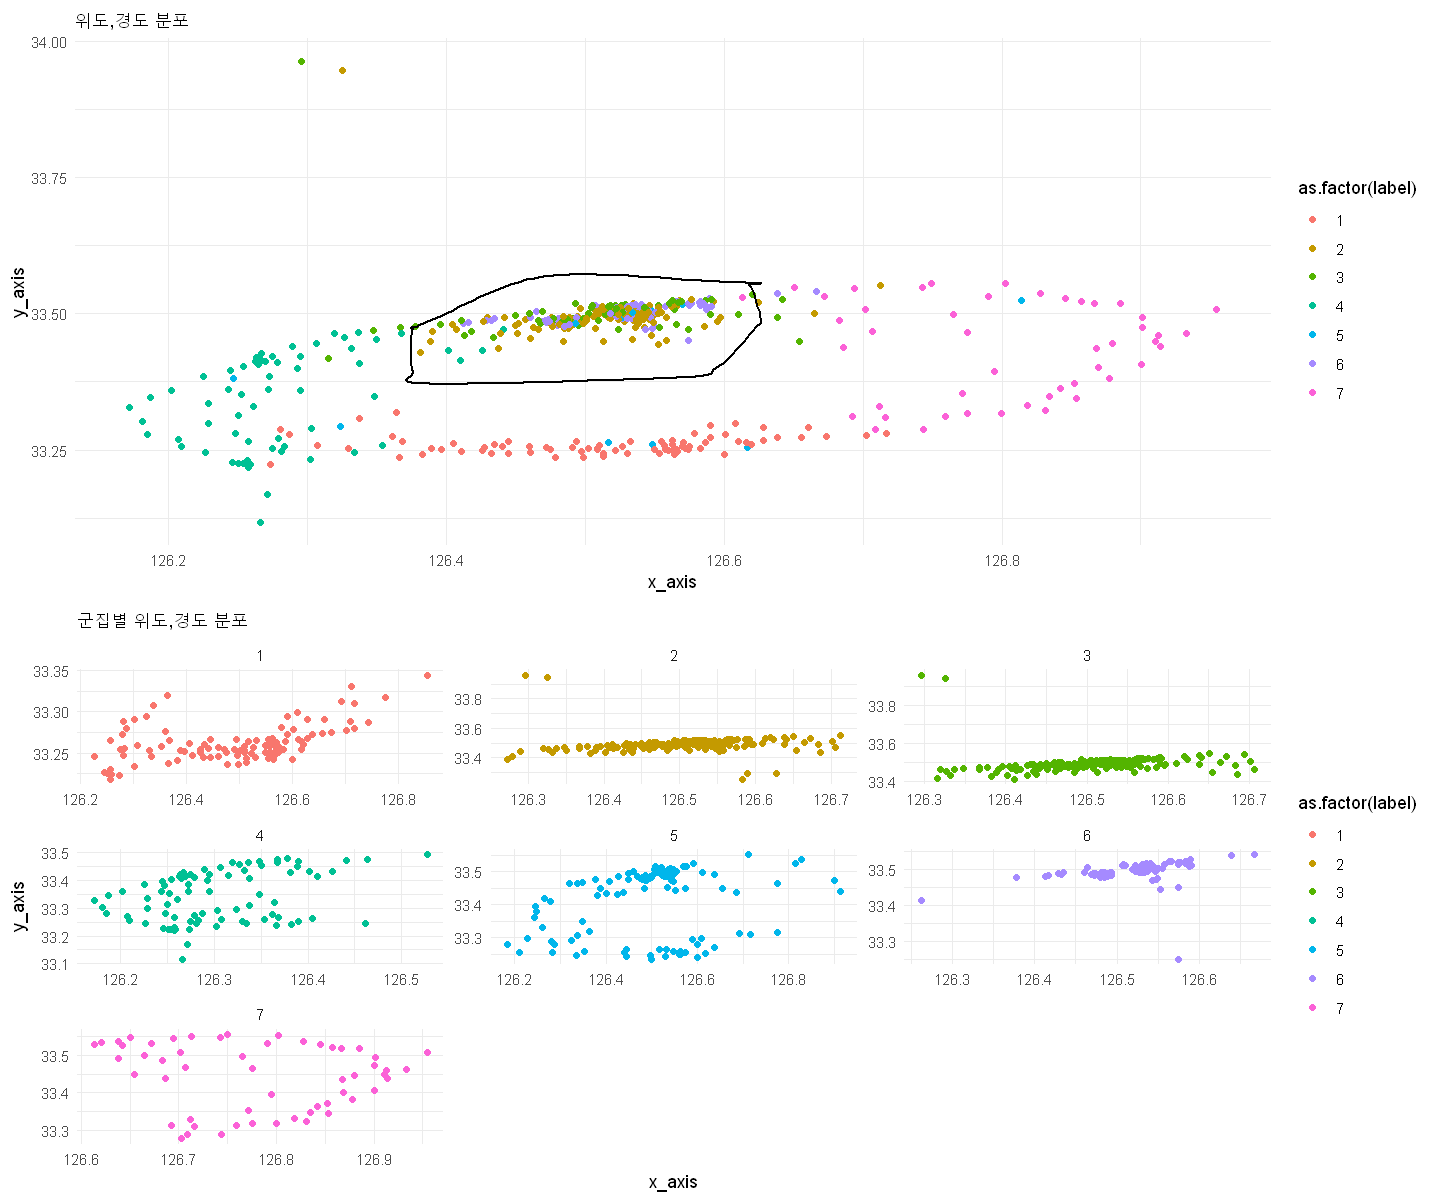

In [401]:
options(repr.plot.width=12, repr.plot.height=10)

library(ggalt)

jeju_density = jeju  %>%
                filter(x_axis>=126.4 & x_axis<=126.6) %>% 
                filter(y_axis>=33.35 & y_axis<=33.6)

p1=ggplot(jeju,aes(x_axis,y_axis,colour=as.factor(label)))+
    geom_point()+
    theme(plot.title = element_text(hjust = 0.5))+
    theme_minimal()+
    ggtitle("위도,경도 분포")+
    geom_encircle(aes(x=x_axis, y=y_axis), 
                data=jeju_density, 
                color="black", 
                size=2, 
                expand=0.08)   # encircle



p2=ggplot(jeju,aes(x_axis,y_axis,colour=as.factor(label)))+
    geom_point()+
    theme(plot.title = element_text(hjust = 0.5))+
    theme_minimal()+
    ggtitle("군집별 위도,경도 분포")+
    facet_wrap(label~.,scales="free")

grid.arrange(p1,p2,nrow=2)

위의 그림에서 검은색 circle에서 1번과 7번을 제외한 나머지 군집들이 밀집되는 분포를 가지고 있습니다.

circle 내 데이터는 제주도 데이터의 약 56%나 차지하고 있습니다.

circle 내 데이터는 어떤 지역인지 확인해보겠습니다.

In [402]:
table(jeju$label) #제주 군집
table(jeju_density$label) #circle 군집


   1    2    3    4    5    6    7 
1700 2320 1835 1289  185 2043 1050 


   2    3    4    5    6 
2105 1634   14  107 2000 

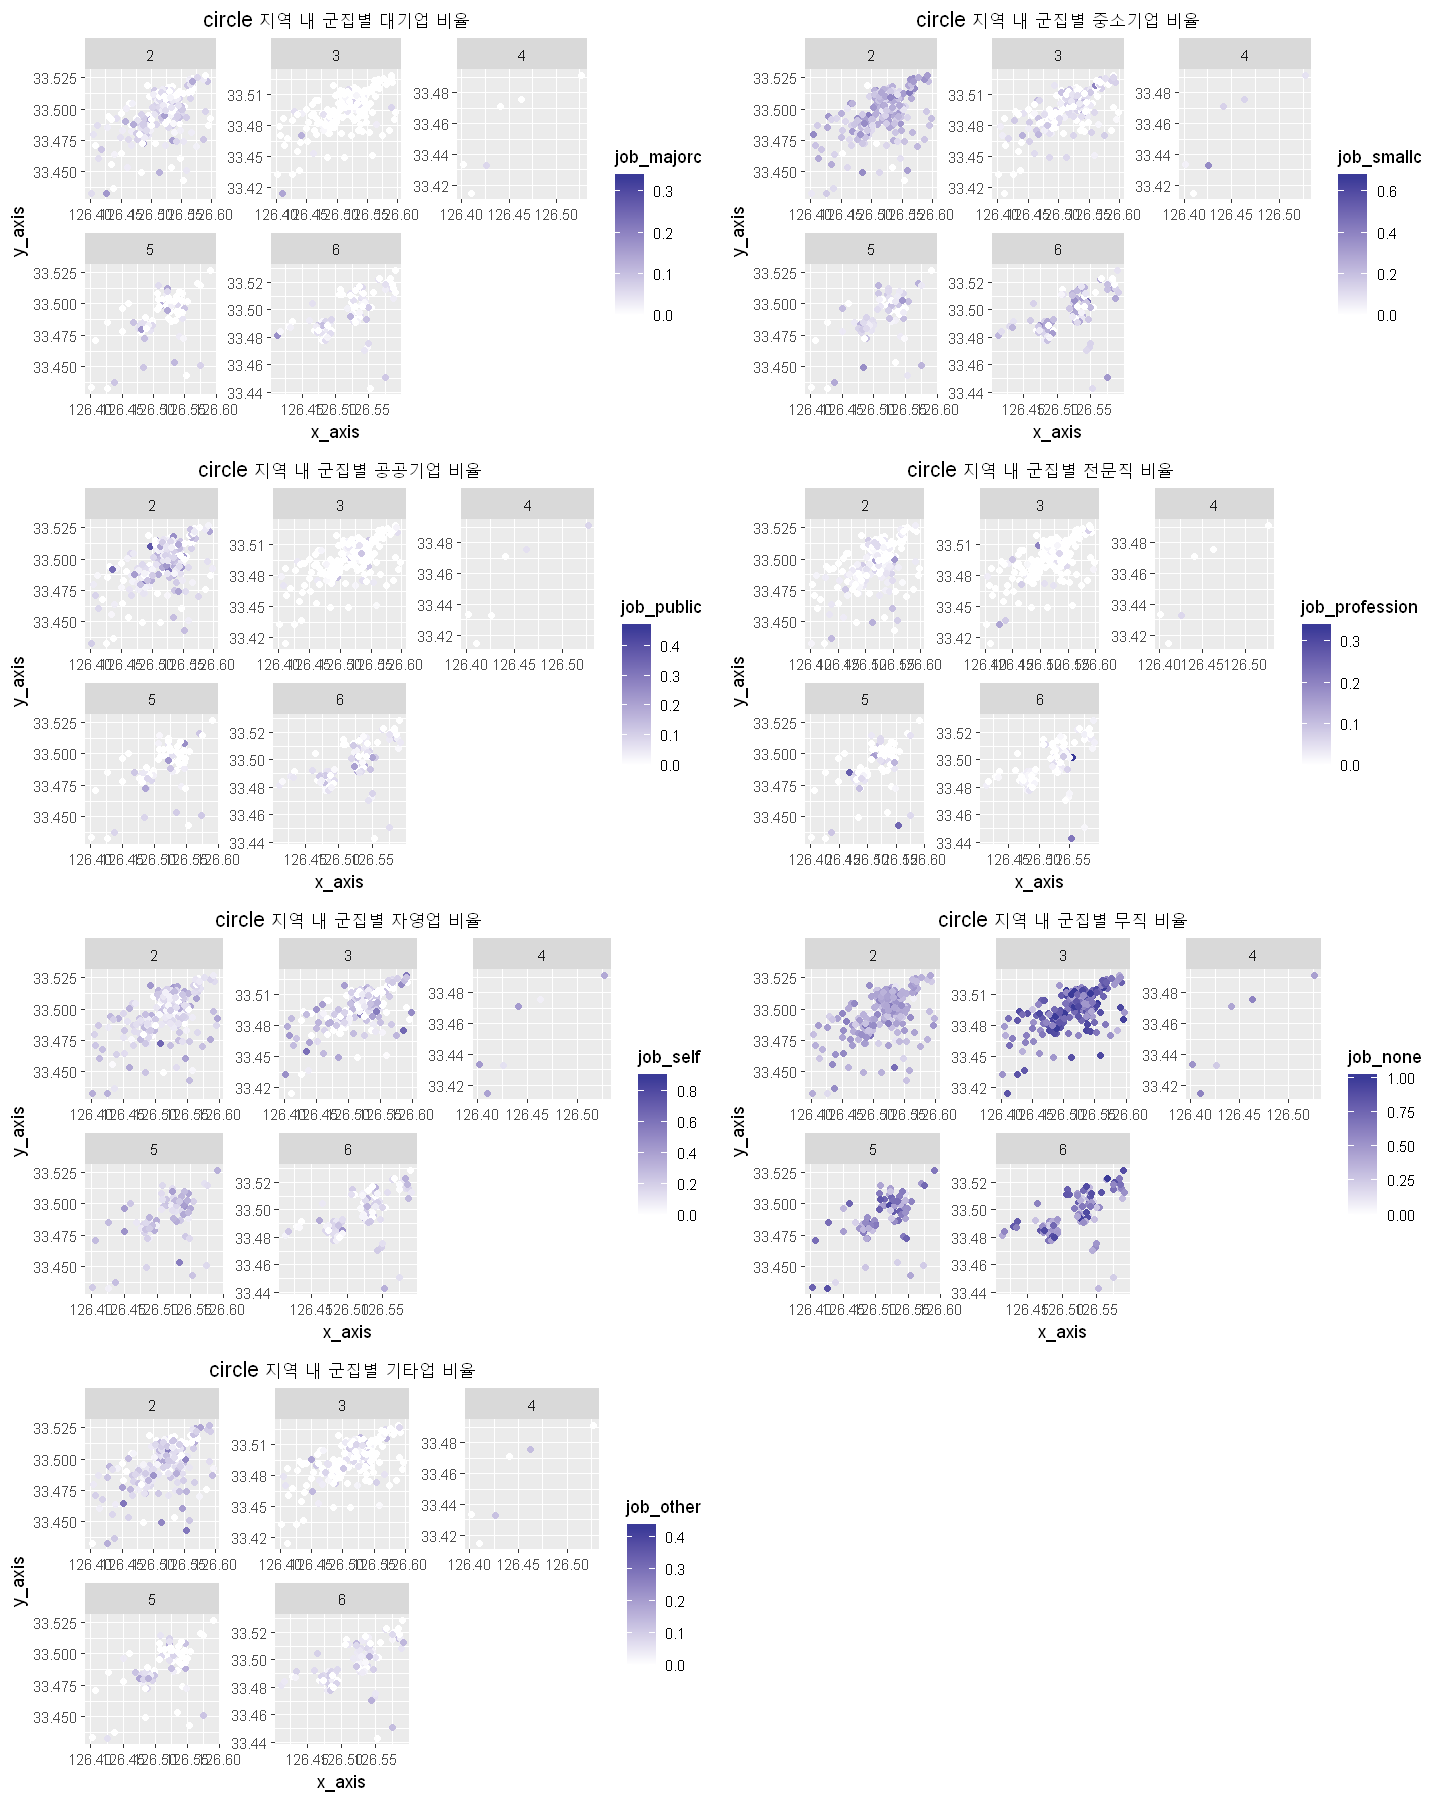

In [403]:
options(repr.plot.width=12, repr.plot.height=15)



p1= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_majorc))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 대기업 비율")

p2= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_smallc))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 중소기업 비율")

p3= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_public))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 공공기업 비율")

p4= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_profession))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 전문직 비율")

p5= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_self))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 자영업 비율")

p6= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_none))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 무직 비율")

p7= ggplot(jeju_density,aes(x_axis,y_axis,colour=job_other))+
    geom_point()+
    scale_colour_gradient2()+
    theme(plot.title = element_text(hjust = 0.5))+
    facet_wrap(label~.,scales="free")+
    ggtitle("circle 지역 내 군집별 기타업 비율")

grid.arrange(p1,p2,p3,p4,p5,p6,p7,nrow=4)

circle지역에서 대기업, 중소기업, 공공기업, 기타업을 보았을 떄 2번 군집의 비율이 높은 것으로 확인됩니다.

이는 2번 군집의 직장이 대부분 circle 지역이라는 것을 유추할 수 있습니다.

무직비율은 3번이 제일 높으며 지역 내에서 모든 군집이 꽤 높은 비율을 갖고 있습니다.

우리는 위 그래프를 통해 circle 지역이 회사가 많고 무직(주부,학생)이 많은 제주도 지역의 중심지라는 것을 파악할 수 있습니다.